In [1]:
import csv
import torch
import shutil
from tqdm import tqdm
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from transformers import BeitForImageClassification, BeitConfig

c:\Users\71559\anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Rearrange Dataset to use ImageFolder

In [3]:
# make sure you have following floder
# dataset
#   |-0.0
#   |-0.3333333333333333
#   |-0.6666666666666666
#   |-1.0
# dataset_test, dataset_mono and dataset_poly should be similar

import csv
import shutil

filePath = []
fileLables = []
ty = []

with open("./elpv_dataset/labels.csv", newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter='\t')
    for row in csvreader:
        ll = row[0].split(" ")
        filePath.append("./elpv_dataset/"+ll[0])
        fileLables.append(ll[2])
        ty.append(ll[-1])

num_of_train = 1968

for index, i in enumerate(fileLables):
    if ty[index] == "mono":
        shutil.copy(filePath[index],"./dataset_mono/"+str(i)+"/"+filePath[index].split("/")[-1])
    if ty[index] == "poly":
        shutil.copy(filePath[index],"./dataset_poly/"+str(i)+"/"+filePath[index].split("/")[-1])

for index, i in enumerate(fileLables[:num_of_train]):
    shutil.copy(filePath[index],"./dataset_train/"+str(i)+"/"+filePath[index].split("/")[-1])

for index, i in enumerate(fileLables[num_of_train:]):
    shutil.copy(filePath[index],"./dataset_test/"+str(i)+"/"+filePath[index].split("/")[-1])

## Loading Data

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageFolder(root='./dataset_train', transform=transform)
val_dataset = ImageFolder(root='./dataset_train', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## load pretrained model

In [5]:
config = BeitConfig.from_pretrained('microsoft/beit-base-patch16-224')
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224', config=config)

model.classifier = torch.nn.Linear(model.config.hidden_size, len(train_dataset.classes))

## training

In [6]:
device = torch.device("cuda")
epoch_num = 20
lr=1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss().to(device)

model.to(device)

# training
for epoch in range(epoch_num):
    
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_num = 0
        
        for x, label in val_loader:
            x, label = x.to(device), label.to(device)
            logits = model(x).logits
            pred = logits.argmax(dim=1)
            total_correct += torch.eq(pred,label).float().sum()
            total_num += x.size(0)
            
        acc = total_correct / total_num
        tqdm.write("epoch:{}, acc :{}".format(epoch,acc))

epoch:0, acc :0.6509146094322205
epoch:1, acc :0.7057926654815674
epoch:2, acc :0.7164633870124817
epoch:3, acc :0.7362804412841797
epoch:4, acc :0.7580029964447021
epoch:5, acc :0.762576162815094
epoch:6, acc :0.8147865533828735
epoch:7, acc :0.8216463327407837
epoch:8, acc :0.8487042188644409
epoch:9, acc :0.8410822749137878
epoch:10, acc :0.8925304412841797
epoch:11, acc :0.8967225551605225
epoch:12, acc :0.9077743291854858
epoch:13, acc :0.9325457215309143
epoch:14, acc :0.9241615533828735
epoch:15, acc :0.9405487179756165
epoch:16, acc :0.9424542188644409
epoch:17, acc :0.961509108543396
epoch:18, acc :0.9394054412841797
epoch:19, acc :0.9401676654815674


## Testing

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1014
           1       0.79      0.91      0.85       211
           2       0.97      0.67      0.80        95
           3       0.94      0.98      0.96       648

    accuracy                           0.93      1968
   macro avg       0.92      0.88      0.89      1968
weighted avg       0.94      0.93      0.93      1968



Text(0.5, 0.98, 'Confusion Matrix')

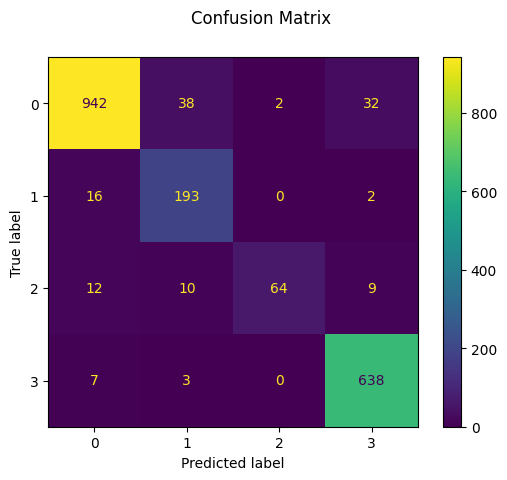

In [16]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

with torch.no_grad():
    preds = []
    truth = []
    for images, multi_labels in val_loader:
        images = images.to(device)
        multi_labels = multi_labels.to(device)
        multi_outputs = model(images).logits
        multi_preds = torch.argmax(multi_outputs, dim=-1)
        preds += multi_preds.reshape(-1).tolist()
        truth += multi_labels.reshape(-1).tolist()
        

# all
print(classification_report(truth, preds))
disp = ConfusionMatrixDisplay.from_predictions(truth, preds)
disp.figure_.suptitle("Confusion Matrix")

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       588
           1       0.69      0.87      0.77       117
           2       1.00      0.39      0.56        56
           3       0.89      0.97      0.93       313

    accuracy                           0.89      1074
   macro avg       0.88      0.78      0.80      1074
weighted avg       0.90      0.89      0.89      1074



Text(0.5, 0.98, 'Confusion Matrix Mono')

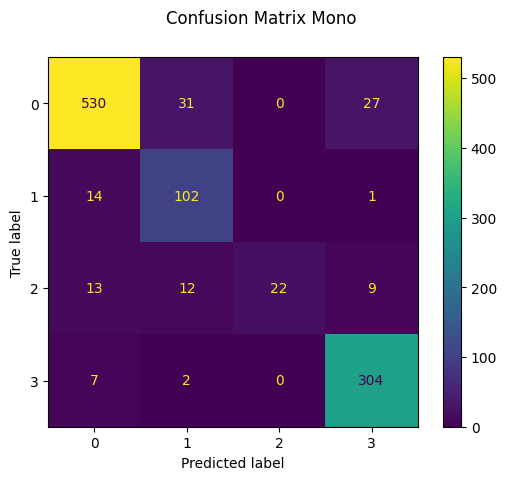

In [11]:
mono_dataset = ImageFolder(root='./dataset_mono/', transform=transform)
mono_loader = DataLoader(mono_dataset, batch_size=32, shuffle=True)

with torch.no_grad():
    preds = []
    truth = []
    for images, multi_labels in mono_loader:
        images = images.to(device)
        multi_labels = multi_labels.to(device)
        multi_outputs = model(images).logits
        multi_preds = torch.argmax(multi_outputs, dim=-1)
        preds += multi_preds.reshape(-1).tolist()
        truth += multi_labels.reshape(-1).tolist()

print(classification_report(truth, preds))
disp = ConfusionMatrixDisplay.from_predictions(truth, preds)
disp.figure_.suptitle("Confusion Matrix Mono")

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       920
           1       0.95      0.96      0.95       178
           2       0.96      0.90      0.93        50
           3       0.98      0.97      0.98       402

    accuracy                           0.97      1550
   macro avg       0.97      0.95      0.96      1550
weighted avg       0.97      0.97      0.97      1550



Text(0.5, 0.98, 'Confusion Matrix Poly')

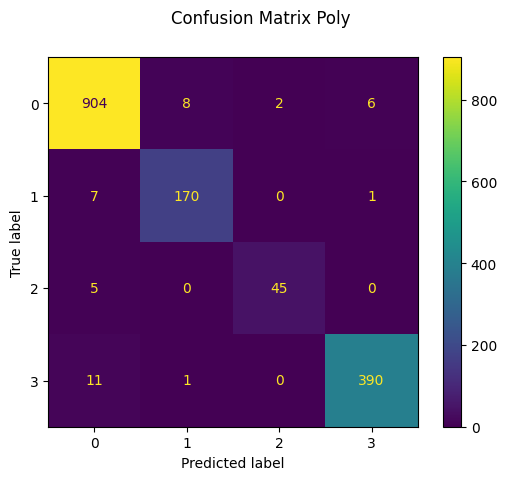

In [12]:
poly_dataset = ImageFolder(root='./dataset_poly', transform=transform)
poly_loader = DataLoader(poly_dataset, batch_size=32, shuffle=True)

with torch.no_grad():
    preds = []
    truth = []
    for images, multi_labels in poly_loader:
        images = images.to(device)
        multi_labels = multi_labels.to(device)
        multi_outputs = model(images).logits
        multi_preds = torch.argmax(multi_outputs, dim=-1)
        preds += multi_preds.reshape(-1).tolist()
        truth += multi_labels.reshape(-1).tolist()

print(classification_report(truth, preds))
disp = ConfusionMatrixDisplay.from_predictions(truth, preds)
disp.figure_.suptitle("Confusion Matrix Poly")